In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Dropout, Input, Lambda, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report,roc_auc_score
from sklearn import metrics
import seaborn as sns
from tensorflow.keras.models import load_model
import pandas as pd
import random


In [2]:
SIZE = 256
numClasses = 8

train_path = "Dataset_finalised/train"
val_path = "Dataset_finalised/val"
test_path = "Dataset_finalised/test"

# Image loading and augmentation

In [3]:

train_datagen = ImageDataGenerator(
    rotation_range=40,
    brightness_range=[0.2,1.2],
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True, 
    fill_mode='nearest')

train_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (SIZE, SIZE),
                                                 batch_size = 32 )

valid_set = ImageDataGenerator().flow_from_directory(val_path,
                                            target_size = (SIZE, SIZE),
                                            batch_size = 32 )

test_set = ImageDataGenerator().flow_from_directory(test_path,
                                            target_size = (SIZE, SIZE),
                                            batch_size = 32, shuffle=False )


Found 2792 images belonging to 8 classes.
Found 400 images belonging to 8 classes.
Found 808 images belonging to 8 classes.


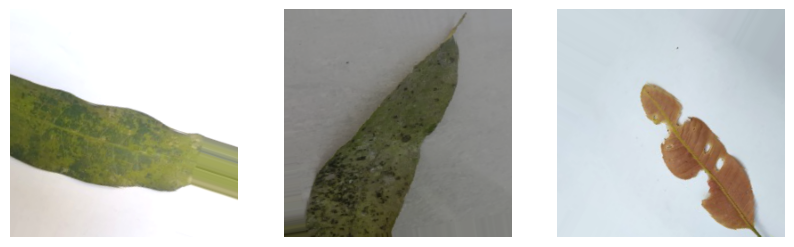

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,10))
for i in range(3):
    batch=next(train_set)   
    img=batch[0][0]  
    image = img.astype('uint8')
    image = np.squeeze(image)
    ax[i].imshow(image)
    ax[i].axis('off')

In [4]:
import glob

class_names = []

for directory in glob.glob("Dataset_finalised/train/*"):
    label = os.path.basename(os.path.normpath(directory))
    class_names.append(label)

print(class_names)

['Anthracnose', 'Bacterial Canker', 'Cutting Weevil', 'Die Back', 'Gall Midge', 'Healthy', 'Powdery Mildew', 'Sooty Mould']


In [6]:
def plot_history(model, history):
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.axis(ymin=0.4,ymax=1)
    plt.grid()
    plt.title(f'{model.name} accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.grid()
    plt.title(f'{model.name} loss')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

In [26]:
test_labels = test_set.classes

# Resnet50 Base Model

In [3]:
resnetBase = tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(SIZE,SIZE,3),
    pooling="avg",
    classes=numClasses,
)

for layer in resnetBase.layers[:-5]:
    layer.trainable = False
    
resnetBase.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 256, 256, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 262, 262, 3)       │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 128, 128, 64)      │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 128, 128, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 128, 128, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 130, 130, 64)      │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 64, 64, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 64, 64, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 64, 64, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 64, 64, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 64, 64, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 64, 64, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 64, 64, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 64, 64, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 64, 64, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 1,054,720 (4.02 MB)

 Non-trainable params: 22,532,992 (85.96 MB)

# Resnet50 Model

In [4]:

resnet_model = Sequential()
resnet_model.add(Lambda(
                    tf.keras.applications.resnet50.preprocess_input, 
                    input_shape=(SIZE,SIZE,3)))

resnet_model.add(resnetBase)
resnet_model.add(Flatten())
resnet_model.add(Dense(256, activation='relu'))
resnet_model.add(Dense(numClasses, activation='softmax',name='output') )

resnet_model.summary()

C:\Users\ridma\anaconda3\Lib\site-packages\keras\src\layers\core\lambda_layer.py:65: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                      │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 2048)                │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,114,312 (91.99 MB)

 Trainable params: 1,581,320 (6.03 MB)

 Non-trainable params: 22,532,992 (85.96 MB)

In [7]:


resnet_model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

Resnet_history = resnet_model.fit(
    train_set,
    validation_data=valid_set,
    epochs=15,
    
)

Epoch 1/15


C:\Users\ridma\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


88/88 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step - accuracy: 0.8564 - loss: 0.4014 - val_accuracy: 0.9825 - val_loss: 0.0796
Epoch 2/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step - accuracy: 0.9747 - loss: 0.0821 - val_accuracy: 0.9875 - val_loss: 0.0395
Epoch 3/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step - accuracy: 0.9764 - loss: 0.0499 - val_accuracy: 0.9375 - val_loss: 0.1995
Epoch 4/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 192s 2s/step - accuracy: 0.9899 - loss: 0.0300 - val_accuracy: 0.9900 - val_loss: 0.0369
Epoch 5/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 190s 2s/step - accuracy: 0.9939 - loss: 0.0162 - val_accuracy: 0.9900 - val_loss: 0.0236
Epoch 6/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 191s 2s/step - accuracy: 0.9921 - loss: 0.0273 - val_accuracy: 0.9975 - val_loss: 0.0074
Epoch 7/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 191s 2s/step - accuracy: 0.9904 - loss: 0.0351 - val_accuracy: 1.0000 - val_loss: 0.0016
Epoch 8/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 192s 2s/step - accuracy: 0.9964 - loss: 0.0093 - val_accuracy: 1.0000 - val_loss: 0.

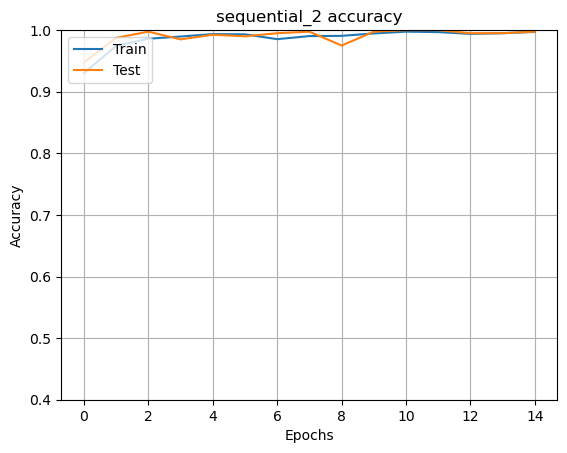

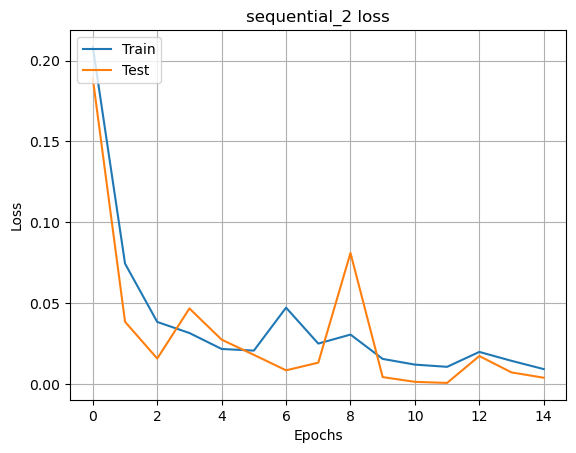

In [83]:
plot_history(resnet_model, Resnet_history)


# Evaluating Resnet50 model

In [19]:
train_loss, train_acc = resnet_model.evaluate(train_set)

88/88 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.9958 - loss: 0.0121


In [20]:
test_loss, test_acc = resnet_model.evaluate(test_set)

26/26 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.9956 - loss: 0.0178


In [31]:
predResnet = resnet_model.predict(test_set) 
classResnet=np.argmax(predResnet,axis=1)

correct_predictions = np.nonzero(classResnet == test_labels)[0]
incorrect_predictions = np.nonzero(classResnet != test_labels)[0]

print( "Correct classifications: ", len(correct_predictions))
print( "Misclassifications: ", len(incorrect_predictions))

26/26 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step
Correct classifications:  804
Misclassifications:  4


In [32]:

log_loss_resnet = metrics.log_loss(test_labels,  predResnet)
print("Log loss score:", log_loss_resnet)

Log loss score: 0.018990403242268673


C:\Users\ridma\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


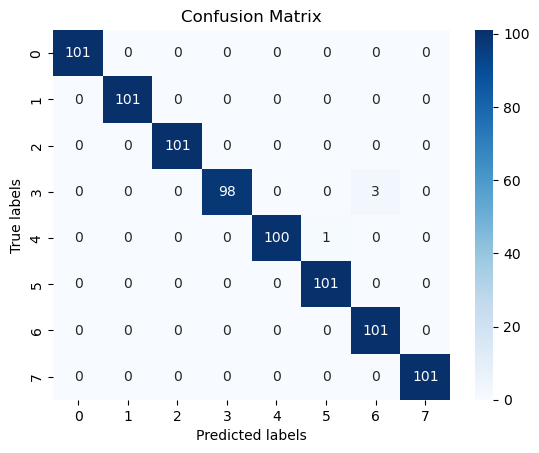

In [34]:
cm_resnet = confusion_matrix(test_labels, classResnet)

sns.heatmap(cm_resnet, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [35]:
print(classification_report(test_labels, classResnet))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       101
           1       1.00      1.00      1.00       101
           2       1.00      1.00      1.00       101
           3       1.00      0.97      0.98       101
           4       1.00      0.99      1.00       101
           5       0.99      1.00      1.00       101
           6       0.97      1.00      0.99       101
           7       1.00      1.00      1.00       101

    accuracy                           1.00       808
   macro avg       1.00      1.00      1.00       808
weighted avg       1.00      1.00      1.00       808



# InceptionV3 Base model

In [5]:

inceptionBase = tf.keras.applications.inception_v3.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=(SIZE,SIZE,3),
    pooling="avg",
    classes=numClasses,)

for layer in inceptionBase.layers[:-4]:
    layer.trainable = False
    
inceptionBase.summary()

Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 256, 256, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 127, 127, 32)      │             864 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 127, 127, 32)      │              96 │ conv2d[0][0]               │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation (Activation)       │ (None, 127, 127, 32)      │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 125, 125, 32)      │           9,216 │ activation[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 125, 125, 32)      │              96 │ conv2d_1[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_1 (Activation)     │ (None, 125, 125, 32)      │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 125, 125, 64)      │          18,432 │ activation_1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 125, 125, 64)      │             192 │ conv2d_2[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_2 (Activation)     │ (None, 125, 125, 64)      │               0 │ batch_normalization_2[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 62, 62, 64)        │               0 │ activation_2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 62, 62, 80)        │           5,120 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_3         │ (None, 62, 62, 80)        │             240 │ conv2d_3[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_3 (Activation)     │ (None, 62, 62, 80)        │               0 │ batch_normalization_3[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 60, 60, 192)       │         138,240 │ activation_3[0][0]         │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,802,784 (83.17 MB)

# InceptionV3 model

In [6]:
inception_model = Sequential()
inception_model.add(Lambda(
                    tf.keras.applications.inception_v3.preprocess_input, 
                    input_shape=(SIZE,SIZE,3)))

inception_model.add(inceptionBase)
inception_model.add(Flatten())
inception_model.add(Dense(256, activation='relu'))
inception_model.add(Dense(numClasses, activation='softmax',name='output') )

inception_model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lambda_1 (Lambda)                    │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_v3 (Functional)            │ (None, 2048)                │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,329,384 (85.18 MB)

 Trainable params: 526,600 (2.01 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [10]:

inception_model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

Inception_history = inception_model.fit(
    train_set,
    validation_data=valid_set,
    epochs=25,
    
)


Epoch 1/25
88/88 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - accuracy: 0.7231 - loss: 0.8259 - val_accuracy: 0.8850 - val_loss: 0.2979
Epoch 2/25
88/88 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 0.9299 - loss: 0.1964 - val_accuracy: 0.9175 - val_loss: 0.2292
Epoch 3/25
88/88 ━━━━━━━━━━━━━━━━━━━━ 132s 1s/step - accuracy: 0.9510 - loss: 0.1449 - val_accuracy: 0.9425 - val_loss: 0.1378
Epoch 4/25
88/88 ━━━━━━━━━━━━━━━━━━━━ 134s 1s/step - accuracy: 0.9543 - loss: 0.1314 - val_accuracy: 0.9475 - val_loss: 0.1341
Epoch 5/25
88/88 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - accuracy: 0.9585 - loss: 0.1217 - val_accuracy: 0.9525 - val_loss: 0.1273
Epoch 6/25
88/88 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - accuracy: 0.9755 - loss: 0.0806 - val_accuracy: 0.9450 - val_loss: 0.1288
Epoch 7/25
88/88 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - accuracy: 0.9718 - loss: 0.0900 - val_accuracy: 0.9425 - val_loss: 0.1482
Epoch 8/25
88/88 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.9689 - loss: 0.0955 - val_accuracy: 0.9775 - v

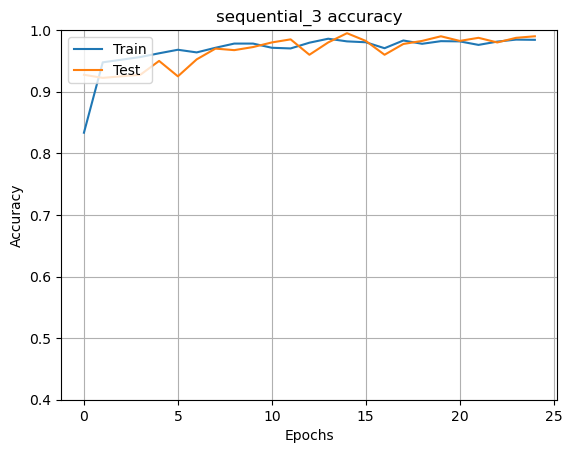

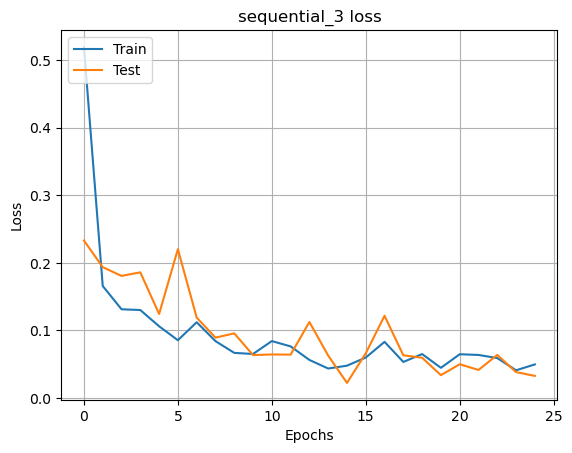

In [36]:
plot_history(inception_model, Inception_history)

# Evaluating InceptionV3 model

In [37]:
train_loss, train_acc = inception_model.evaluate(train_set)

88/88 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.9903 - loss: 0.0281


In [22]:
test_loss, test_acc = inception_model.evaluate(test_set)

26/26 ━━━━━━━━━━━━━━━━━━━━ 24s 907ms/step - accuracy: 0.9803 - loss: 0.0749


In [38]:
predInception = inception_model.predict(test_set) 
classInception=np.argmax(predInception,axis=1)

correct_predictions = np.nonzero(classInception == test_labels)[0]
incorrect_predictions = np.nonzero(classInception != test_labels)[0]

print( "Correct classifications: ", len(correct_predictions))
print( "Misclassifications: ", len(incorrect_predictions))

26/26 ━━━━━━━━━━━━━━━━━━━━ 22s 844ms/step
Correct classifications:  791
Misclassifications:  17


In [39]:

log_loss_inception = metrics.log_loss(test_labels,  predInception)
print("Log loss score:", log_loss_resnet)

Log loss score: 0.018990403242268673


C:\Users\ridma\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


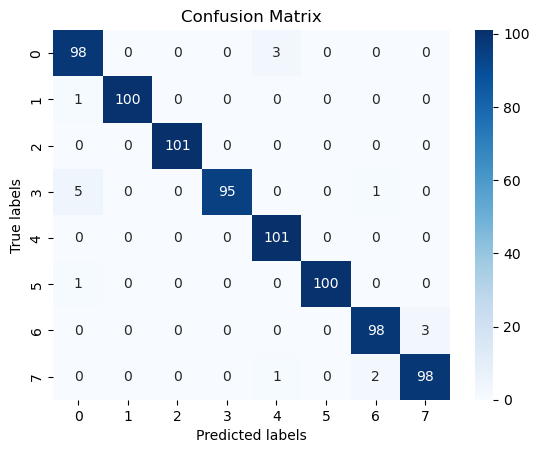

In [40]:
cm_inception = confusion_matrix(test_labels, classInception)

sns.heatmap(cm_inception, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [41]:
print(classification_report(test_labels, classInception))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       101
           1       1.00      0.99      1.00       101
           2       1.00      1.00      1.00       101
           3       1.00      0.94      0.97       101
           4       0.96      1.00      0.98       101
           5       1.00      0.99      1.00       101
           6       0.97      0.97      0.97       101
           7       0.97      0.97      0.97       101

    accuracy                           0.98       808
   macro avg       0.98      0.98      0.98       808
weighted avg       0.98      0.98      0.98       808



# Xception Base model

In [7]:

xceptionBase = tf.keras.applications.xception.Xception(
    include_top=False,
    weights="imagenet",
    input_shape=(SIZE,SIZE,3),
    pooling="avg",
    classes=numClasses,)

for layer in xceptionBase.layers[:-4]:
    layer.trainable = False
    
xceptionBase.summary()

Model: "xception"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)    │ (None, 256, 256, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv1 (Conv2D)         │ (None, 127, 127, 32)      │             864 │ input_layer_4[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv1_bn               │ (None, 127, 127, 32)      │             128 │ block1_conv1[0][0]         │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv1_act (Activation) │ (None, 127, 127, 32)      │               0 │ block1_conv1_bn[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv2 (Conv2D)         │ (None, 125, 125, 64)      │          18,432 │ block1_conv1_act[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv2_bn               │ (None, 125, 125, 64)      │             256 │ block1_conv2[0][0]         │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv2_act (Activation) │ (None, 125, 125, 64)      │               0 │ block1_conv2_bn[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_sepconv1               │ (None, 125, 125, 128)     │           8,768 │ block1_conv2_act[0][0]     │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_sepconv1_bn            │ (None, 125, 125, 128)     │             512 │ block2_sepconv1[0][0]      │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_sepconv2_act           │ (None, 125, 125, 128)     │               0 │ block2_sepconv1_bn[0][0]   │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_sepconv2               │ (None, 125, 125, 128)     │          17,536 │ block2_sepconv2_act[0][0]  │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_sepconv2_bn            │ (None, 125, 125, 128)     │             512 │ block2_sepconv2[0][0]      │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_94 (Conv2D)            │ (None, 63, 63, 128)       │           8,192 │ block1_conv2_act[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_pool (MaxPooling2D)    │ (None, 63, 63, 128)       │               

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 3,163,648 (12.07 MB)

 Non-trainable params: 17,697,832 (67.51 MB)

# Xception model

In [8]:
xception_model = Sequential()
xception_model.add(Lambda(
                    tf.keras.applications.xception.preprocess_input, 
                    input_shape=(SIZE,SIZE,3)))

xception_model.add(xceptionBase)
xception_model.add(Flatten())
xception_model.add(Dense(256, activation='relu'))
xception_model.add(Dense(numClasses, activation='softmax',name='output') )

xception_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lambda_2 (Lambda)                    │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ xception (Functional)                │ (None, 2048)                │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,388,080 (81.59 MB)

 Trainable params: 3,690,248 (14.08 MB)

 Non-trainable params: 17,697,832 (67.51 MB)

In [13]:
xception_model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

Xception_history = xception_model.fit(
    train_set,
    validation_data=valid_set,
    epochs=15,
    
)


Epoch 1/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 246s 3s/step - accuracy: 0.8117 - loss: 0.5424 - val_accuracy: 0.9950 - val_loss: 0.0180
Epoch 2/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 247s 3s/step - accuracy: 0.9752 - loss: 0.0790 - val_accuracy: 0.9400 - val_loss: 0.1787
Epoch 3/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 248s 3s/step - accuracy: 0.9612 - loss: 0.1232 - val_accuracy: 0.9825 - val_loss: 0.0446
Epoch 4/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 249s 3s/step - accuracy: 0.9777 - loss: 0.0542 - val_accuracy: 0.9950 - val_loss: 0.0159
Epoch 5/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 249s 3s/step - accuracy: 0.9800 - loss: 0.0542 - val_accuracy: 0.9900 - val_loss: 0.0337
Epoch 6/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 251s 3s/step - accuracy: 0.9892 - loss: 0.0383 - val_accuracy: 1.0000 - val_loss: 0.0038
Epoch 7/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 251s 3s/step - accuracy: 0.9893 - loss: 0.0253 - val_accuracy: 0.9975 - val_loss: 0.0111
Epoch 8/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 252s 3s/step - accuracy: 0.9890 - loss: 0.0362 - val_accuracy: 0.9875 - v

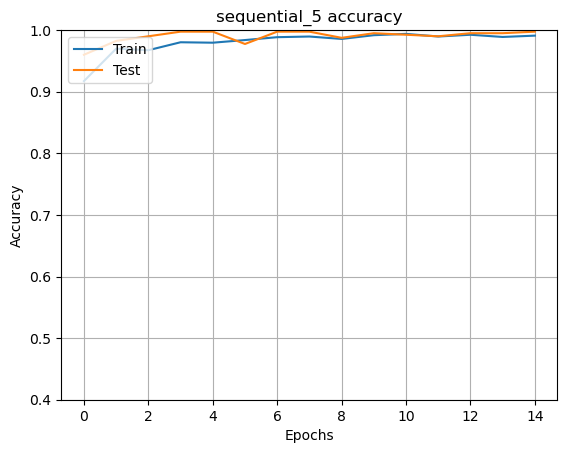

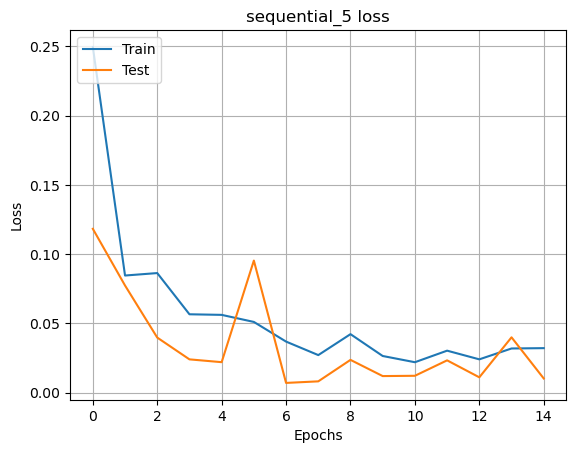

In [42]:
plot_history(xception_model, Xception_history)

# Evaluating Xception model

In [43]:
train_loss, train_acc = xception_model.evaluate(train_set)

88/88 ━━━━━━━━━━━━━━━━━━━━ 189s 2s/step - accuracy: 0.9977 - loss: 0.0095


In [25]:
test_loss, test_acc = xception_model.evaluate(test_set)

26/26 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.9891 - loss: 0.0365


In [45]:
predXception = xception_model.predict(test_set) 
classXception=np.argmax(predXception,axis=1)

correct_predictions = np.nonzero(classXception == test_labels)[0]
incorrect_predictions = np.nonzero(classXception != test_labels)[0]

print( "Correct classifications: ", len(correct_predictions))
print( "Misclassifications: ", len(incorrect_predictions))

26/26 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step
Correct classifications:  800
Misclassifications:  8


In [46]:

log_loss_inception = metrics.log_loss(test_labels,  predXception)
print("Log loss score:", log_loss_resnet)

Log loss score: 0.018990403242268673


C:\Users\ridma\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


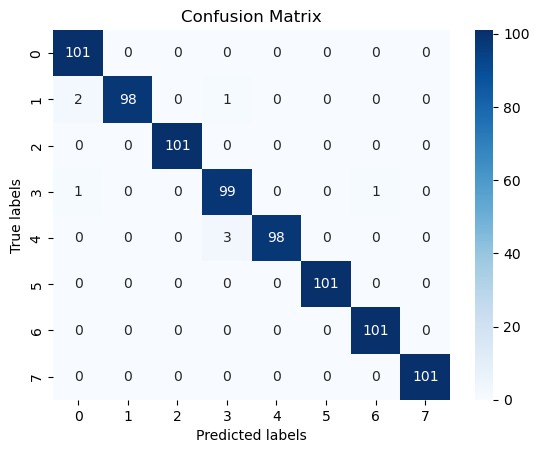

In [84]:
cm_xception = confusion_matrix(test_labels, classXception)

sns.heatmap(cm_xception, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [48]:
print(classification_report(test_labels, classXception))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       101
           1       1.00      0.97      0.98       101
           2       1.00      1.00      1.00       101
           3       0.96      0.98      0.97       101
           4       1.00      0.97      0.98       101
           5       1.00      1.00      1.00       101
           6       0.99      1.00      1.00       101
           7       1.00      1.00      1.00       101

    accuracy                           0.99       808
   macro avg       0.99      0.99      0.99       808
weighted avg       0.99      0.99      0.99       808



# Save Model

In [49]:
resnet_model.save("Resnet.h5")
inception_model.save("Inception.h5")
xception_model.save("Xception.h5")

# Load models

In [2]:
custom_object1= {'preprocess_input': tf.keras.applications.resnet50.preprocess_input}
custom_object2= {'preprocess_input': tf.keras.applications.inception_v3.preprocess_input}
custom_object3= {'preprocess_input': tf.keras.applications.xception.preprocess_input}

model_1 = load_model('Resnet.h5', custom_objects=custom_object1)
model_2 = load_model('Inception.h5', custom_objects=custom_object2)
model_3 = load_model('Xception.h5', custom_objects=custom_object3)

models = [model_1, model_2, model_3]

# Average Ensemble model

In [27]:
models = [model_1, model_2, model_3]

predVal = [model.predict(test_set) for model in models]
predVal=np.array(predVal)

averageAcc = np.sum(predVal, axis=0)
average_ensemble_prediction = np.argmax(averageAcc, axis=1)

print('Average Ensemble accuracy: ', accuracy_score(test_labels, average_ensemble_prediction)*100)

26/26 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 25s 972ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step
Average Ensemble accuracy:  99.5049504950495


# Weighted Average Ensemble model

In [34]:

df = pd.DataFrame(columns=['wt1', 'wt2', 'wt3', 'acc'])

for w1 in range(1, 11):
    for w2 in range(1, 11):
        for w3 in range(1, 11):
            weights = [w1 / 10., w2 / 10., w3 / 10.]
            weightVal = np.tensordot(predVal, weights, axes=((0), (0)))
            weightPred = np.argmax(weightVal, axis=1)
            weightAccuracy = accuracy_score(test_labels, weightPred)
            
            new_row = pd.DataFrame({
                'wt1': [weights[0]],
                'wt2': [weights[1]],
                'wt3': [weights[2]],
                'acc': [weightAccuracy * 100]
            })
            
            df = pd.concat([df, new_row], ignore_index=True)

print(df)

max_accuracy = df['acc'].max()
max_accuracy_row = df.loc[df['acc'].idxmax()]

print(f'Maximum Accuracy: {max_accuracy}%')
print('Weights for Maximum Accuracy:')
print(max_accuracy_row)


     wt1  wt2  wt3        acc
0    0.1  0.1  0.1  99.504950
1    0.1  0.1  0.2  99.381188
2    0.1  0.1  0.3  99.257426
3    0.1  0.1  0.4  99.009901
4    0.1  0.1  0.5  99.009901
..   ...  ...  ...        ...
995  1.0  1.0  0.6  99.628713
996  1.0  1.0  0.7  99.628713
997  1.0  1.0  0.8  99.628713
998  1.0  1.0  0.9  99.628713
999  1.0  1.0  1.0  99.504950

[1000 rows x 4 columns]
Maximum Accuracy: 99.75247524752476%
Weights for Maximum Accuracy:
wt1     0.200000
wt2     0.100000
wt3     0.100000
acc    99.752475
Name: 100, dtype: float64


# Best Accuracy and weights of ensemble model

In [35]:
best_weights = [max_accuracy_row['wt1'], max_accuracy_row['wt2'], max_accuracy_row['wt3']]

pred_weight_ensemble = np.tensordot(predVal, best_weights, axes=((0), (0)))
class_weight_ensemble = np.argmax(pred_weight_ensemble, axis=1)

weight_ensemble_accuracy = accuracy_score(test_labels, class_weight_ensemble)

print(f'Weight Ensemble Model Accuracy: {weight_ensemble_accuracy * 100}%')
print(f'Best Weights: {best_weights}')

Weight Ensemble Model Accuracy: 99.75247524752476%
Best Weights: [0.2, 0.1, 0.1]


# Evaluating Weighted Ensemble Model

In [62]:
correct_predictions = np.nonzero(class_weight_ensemble == test_labels)[0]
incorrect_predictions = np.nonzero(class_weight_ensemble != test_labels)[0]

print( "Correct classifications: ", len(correct_predictions))
print( "Misclassifications: ", len(incorrect_predictions))

Correct classifications:  806
Misclassifications:  2


In [64]:

log_loss_weightEnsemble = metrics.log_loss(test_labels,  pred_weight_ensemble)
print("Log loss score:", log_loss_weightEnsemble)

Log loss score: 0.016027917719053177


C:\Users\ridma\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


In [38]:
def softmax(logits):
    exp_logits = np.exp(logits)
    return exp_logits / np.sum(exp_logits, axis=1, keepdims=True)

pred_probabilities = softmax(pred_weight_ensemble)

auc = roc_auc_score(test_labels, pred_probabilities, multi_class="ovr")
print("ROC AUC Score:", auc)

ROC AUC Score: 0.9999964989426807


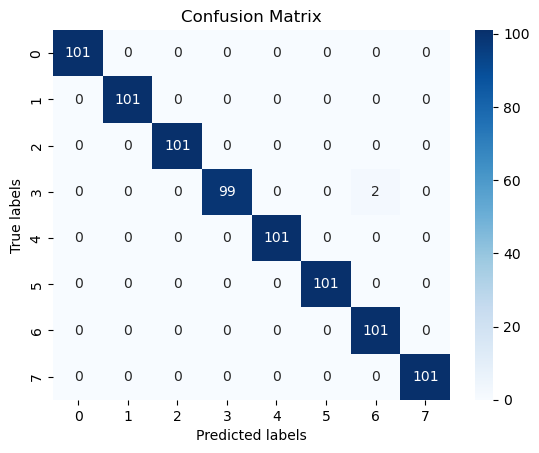

In [65]:
cm_weightEnsemble = confusion_matrix(test_labels, class_weight_ensemble)

sns.heatmap(cm_weightEnsemble, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [66]:
print(classification_report(test_labels, class_weight_ensemble))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       101
           1       1.00      1.00      1.00       101
           2       1.00      1.00      1.00       101
           3       1.00      0.98      0.99       101
           4       1.00      1.00      1.00       101
           5       1.00      1.00      1.00       101
           6       0.98      1.00      0.99       101
           7       1.00      1.00      1.00       101

    accuracy                           1.00       808
   macro avg       1.00      1.00      1.00       808
weighted avg       1.00      1.00      1.00       808



# Predict random Image in the test set using Weighted ensemble model

Random Num:  21
Predicted Label:  Anthracnose
True Label:  Anthracnose


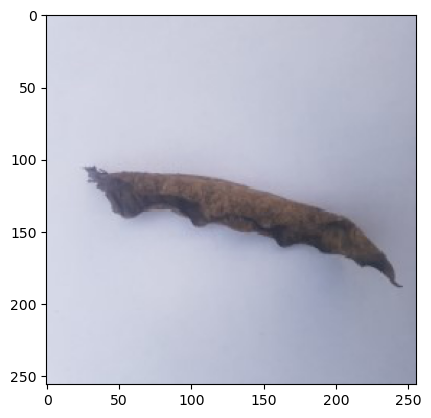

In [82]:
i = random.randint(0,30)
print("Random Num: ",i)

batch=next(test_set)   
img=batch[0][i]  
plt.imshow(img.astype('uint8')) 

print("Predicted Label: ", class_names[int(class_weight_ensemble[i])])
print("True Label: ", class_names[int(test_labels[i])])

# Disease Identification

In [3]:
from keras.preprocessing import image

def predictImage(imagePath):

    test_img = image.load_img(imagePath, target_size = (SIZE, SIZE)) 
    test_image = image.img_to_array(test_img)
    test_image = np.expand_dims(test_image, axis = 0)
        
    pred = [model.predict(test_image) for model in models]
    
    pred=np.array(pred)
        
    result = np.tensordot(pred, [0.2,0.1,0.1], axes=((0), (0))) 
    
    print("Result Array", result)
        
    if np.amax(result) > 0.3: 
        plt.imshow(test_img) 
        print("Classification: ",class_names[int(np.argmax(result,axis=1))])
        print("Max value", np.amax(result))
        print("Max class", np.argmax(result,axis=1))
        
    else:
        print("Can't identify the image, Enter a new valid image")
        print("Max value", np.amax(result))
        

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 987ms/step
Result Array [[2.12862281e-04 4.13905201e-07 5.62114952e-07 8.65413659e-06
  6.38604865e-07 7.39967394e-05 3.10336150e-01 8.93667313e-02]]
Classification:  Powdery Mildew
Max value 0.31033615022897726
Max class [6]


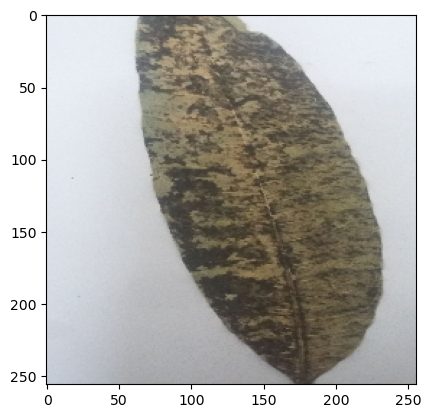

In [21]:
imagePath = 'D:/img2.jpg'
predictImage(imagePath)